<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/Part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle

In [ ]:
run = 1
seed = 1617 * run
np.random.seed(seed)

In [ ]:
from sklearn import preprocessing

def load_data(dataset="Fish"):
    folder = '' # folder = '../data/matlab/'
    mat = scipy.io.loadmat(folder + dataset + '.mat')
    X = mat['X']
    X = X.astype(float)
    y = mat['Y']
    y = y[:, 0]
    return X,y 

def get_labels(y):
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y_ = le.transform(y)
    labels = le.inverse_transform(np.unique(y_))
    return y_, labels

dataset = "Part"
X,y = load_data(dataset=dataset)
y_, labels = get_labels(y)

In [ ]:
inc = 50
no_features = X.shape[1] + inc
j = np.arange(inc,no_features,inc) # [50,4800]

In [ ]:
from skfeature.function.similarity_based import reliefF
from skfeature.function.information_theoretical_based import MRMR
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC as svm

methods = { "reliefF" : reliefF.reliefF, "mrmr": MRMR.mrmr, "chi2": chi2}
results = { "reliefF" : [], "mrmr": [], "chi2": [], "pso": []}
penalty = 'l1'

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

def normalize(X_train, X_test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [ ]:
from Problem import FeatureSelection
from PSO import Swarm

def pso(X,y):
    prob = FeatureSelection(minimized=True, X=X, y=y)
    pop_size = 30
    n_iterations = 100
    no_fea = X.shape[1]
    swarm = Swarm(n_particle=pop_size, length=no_fea, n_iterations=n_iterations,
                        max_pos=1.0, min_pos=0.0, max_vel=0.2, min_vel=-0.2,
                        problem=prob)
    best_sol, best_fit = swarm.iterate()
    sel_fea = np.where(best_sol > prob.threshold)[0]
    return sel_fea

In [ ]:
runs = 15
name = "pso"
folds = 10

for k in tqdm(range(runs)):
    train_accs = []
    test_accs = []
    skf = StratifiedKFold(n_splits=folds, random_state=1234, shuffle=True)

    # DEBUG: Fold counter
    f = 1

    for train, test in skf.split(X, y):
        X_train, X_test = (X[train], X[test])
        y_train, y_test = y[train], y[test]
        X_train, X_test = normalize(X_train, X_test)

        sel_fea = pso(X_train, y_train)

        # DEBUG: Measure progress.
        print(f"Run {k}, fold {f} ")

        model = svm(penalty='l1', dual=False, tol=1e-3, max_iter=5_000)
        model.fit(X_train[:, sel_fea], y_train)

        y_predict = model.predict(X_train[:, sel_fea])
        train_acc = balanced_accuracy_score(y_train, y_predict)
        train_accs.append(train_acc)

        y_predict = model.predict(X_test[:, sel_fea])
        test_acc = balanced_accuracy_score(y_test, y_predict)
        test_accs.append(test_acc)

        # DEBUG: Increment fold counter
        f += 1

    no_fea = len(sel_fea)
    results[name].append((no_fea, np.mean(train_accs), np.mean(test_accs)))

  0%|          | 0/15 [00:00<?, ?it/s]

Run 0, fold 1 
Run 0, fold 2 
Run 0, fold 3 
Run 0, fold 4 
Run 0, fold 5 
Run 0, fold 6 
Run 0, fold 7 
Run 0, fold 8 
Run 0, fold 9 


  7%|▋         | 1/15 [1:01:29<14:20:58, 3689.87s/it]

Run 0, fold 10 
Run 1, fold 1 
Run 1, fold 2 
Run 1, fold 3 
Run 1, fold 4 
Run 1, fold 5 
Run 1, fold 6 
Run 1, fold 7 
Run 1, fold 8 
Run 1, fold 9 


 13%|█▎        | 2/15 [2:00:38<13:01:31, 3607.08s/it]

Run 1, fold 10 
Run 2, fold 1 
Run 2, fold 2 
Run 2, fold 3 
Run 2, fold 4 
Run 2, fold 5 
Run 2, fold 6 
Run 2, fold 7 
Run 2, fold 8 
Run 2, fold 9 


 20%|██        | 3/15 [3:00:39<12:00:51, 3604.28s/it]

Run 2, fold 10 
Run 3, fold 1 
Run 3, fold 2 
Run 3, fold 3 
Run 3, fold 4 
Run 3, fold 5 
Run 3, fold 6 
Run 3, fold 7 
Run 3, fold 8 
Run 3, fold 9 


 27%|██▋       | 4/15 [4:01:14<11:03:00, 3616.43s/it]

Run 3, fold 10 
Run 4, fold 1 
Run 4, fold 2 
Run 4, fold 3 
Run 4, fold 4 
Run 4, fold 5 
Run 4, fold 6 
Run 4, fold 7 
Run 4, fold 8 
Run 4, fold 9 


 33%|███▎      | 5/15 [5:01:18<10:01:58, 3611.83s/it]

Run 4, fold 10 
Run 5, fold 1 
Run 5, fold 2 
Run 5, fold 3 
Run 5, fold 4 
Run 5, fold 5 
Run 5, fold 6 
Run 5, fold 7 
Run 5, fold 8 
Run 5, fold 9 


 40%|████      | 6/15 [6:00:15<8:57:58, 3586.48s/it] 

Run 5, fold 10 
Run 6, fold 1 
Run 6, fold 2 
Run 6, fold 3 
Run 6, fold 4 
Run 6, fold 5 
Run 6, fold 6 
Run 6, fold 7 
Run 6, fold 8 
Run 6, fold 9 


 47%|████▋     | 7/15 [6:59:46<7:57:30, 3581.27s/it]

Run 6, fold 10 
Run 7, fold 1 
Run 7, fold 2 
Run 7, fold 3 
Run 7, fold 4 
Run 7, fold 5 
Run 7, fold 6 
Run 7, fold 7 
Run 7, fold 8 
Run 7, fold 9 


 53%|█████▎    | 8/15 [7:59:57<6:58:55, 3590.83s/it]

Run 7, fold 10 
Run 8, fold 1 
Run 8, fold 2 
Run 8, fold 3 
Run 8, fold 4 
Run 8, fold 5 
Run 8, fold 6 
Run 8, fold 7 
Run 8, fold 8 
Run 8, fold 9 


 60%|██████    | 9/15 [8:57:26<5:54:38, 3546.47s/it]

Run 8, fold 10 
Run 9, fold 1 
Run 9, fold 2 
Run 9, fold 3 
Run 9, fold 4 
Run 9, fold 5 
Run 9, fold 6 
Run 9, fold 7 
Run 9, fold 8 
Run 9, fold 9 


 67%|██████▋   | 10/15 [9:57:30<4:57:01, 3564.29s/it]

Run 9, fold 10 
Run 10, fold 1 
Run 10, fold 2 
Run 10, fold 3 
Run 10, fold 4 
Run 10, fold 5 
Run 10, fold 6 
Run 10, fold 7 
Run 10, fold 8 
Run 10, fold 9 


 73%|███████▎  | 11/15 [10:57:39<3:58:31, 3577.76s/it]

Run 10, fold 10 
Run 11, fold 1 
Run 11, fold 2 
Run 11, fold 3 
Run 11, fold 4 
Run 11, fold 5 
Run 11, fold 6 
Run 11, fold 7 
Run 11, fold 8 
Run 11, fold 9 


 80%|████████  | 12/15 [11:57:47<2:59:21, 3587.00s/it]

Run 11, fold 10 
Run 12, fold 1 
Run 12, fold 2 
Run 12, fold 3 
Run 12, fold 4 
Run 12, fold 5 
Run 12, fold 6 
Run 12, fold 7 
Run 12, fold 8 
Run 12, fold 9 


 87%|████████▋ | 13/15 [12:57:08<1:59:18, 3579.06s/it]

Run 12, fold 10 
Run 13, fold 1 
Run 13, fold 2 
Run 13, fold 3 
Run 13, fold 4 
Run 13, fold 5 
Run 13, fold 6 
Run 13, fold 7 
Run 13, fold 8 
Run 13, fold 9 


 93%|█████████▎| 14/15 [13:57:50<59:58, 3598.18s/it]  

Run 13, fold 10 
Run 14, fold 1 
Run 14, fold 2 
Run 14, fold 3 
Run 14, fold 4 
Run 14, fold 5 
Run 14, fold 6 
Run 14, fold 7 
Run 14, fold 8 
Run 14, fold 9 


100%|██████████| 15/15 [14:56:33<00:00, 3586.26s/it]

Run 14, fold 10 


In [ ]:
with open('results-pso-cloud.pkl', 'wb+') as f:
    pickle.dump(results, f)

In [ ]:
for k in tqdm(j):
    for name, fs_method in methods.items(): 
        if name == "pso":
          continue

        train_accs = []
        test_accs = []
        skf = StratifiedKFold(n_splits=folds, random_state=1234, shuffle=True)

        for train, test in skf.split(X, y):
            X_train, X_test = (X[train], X[test])
            y_train, y_test = y[train], y[test]
            X_train, X_test = normalize(X_train, X_test)

            fs = SelectKBest(fs_method, k=k)
            X_train = fs.fit_transform(X_train, y_train)
            X_test = fs.transform(X_test)

            model = svm(penalty='l1', dual=False, tol=1e-3, max_iter=5_000)
            clf = model.fit(X_train, y_train)

            y_predict = model.predict(X_train)
            train_acc = balanced_accuracy_score(y_train, y_predict)
            train_accs.append(train_acc)
            y_predict = model.predict(X_test)
            test_acc = balanced_accuracy_score(y_test, y_predict)
            test_accs.append(test_acc)

        no_fea = k 
        results[name].append((no_fea, np.mean(train_accs), np.mean(test_accs)))

  8%|▊         | 8/96 [10:19<1:53:56, 77.69s/it]

In [ ]:
with open('results-full-cloud.pkl', 'wb+') as f:
    pickle.dump(results, f)

In [76]:
for name, result in results.items(): 
    if name == "pso":
        assert len(result) == 30, "There are 30 independent runs of PSO"
    else:
        assert len(result) == 96, f"There are 96 results for {name}."

print(results)

{'reliefF': [(50, 0.812469586315087, 0.5847222222222221), (100, 0.9155893685010833, 0.6527777777777778), (150, 0.9307986567918654, 0.6777777777777778), (200, 0.9489223465963705, 0.6888888888888889), (250, 0.9585619228912947, 0.7805555555555556), (300, 0.9720060455798996, 0.7583333333333333), (350, 0.9726293413559967, 0.773611111111111), (400, 0.9730705960077778, 0.773611111111111), (450, 0.9747890865972358, 0.7736111111111111), (500, 0.9782143163382552, 0.8027777777777778), (550, 0.9774904106143495, 0.7972222222222223), (600, 0.9795582594479029, 0.763888888888889), (650, 0.9795582594479029, 0.7847222222222222), (700, 0.9810218197824311, 0.7888888888888889), (750, 0.9810218197824311, 0.7888888888888889), (800, 0.9824366471734892, 0.7888888888888889), (850, 0.9857473432685657, 0.7916666666666667), (900, 0.9843325158775074, 0.7944444444444445), (950, 0.9839442243601836, 0.8125), (1000, 0.9839929573036533, 0.8263888888888887), (1050, 0.9840416902471232, 0.8055555555555556), (1100, 0.983992

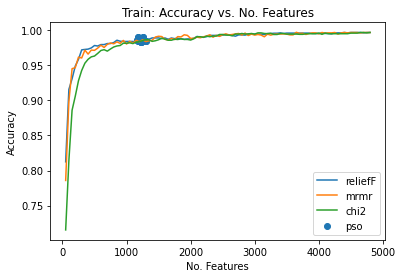

In [72]:
for name, result in results.items():
  k, train, test = zip(*result)
  if name == "pso":
    plt.scatter(k, train, label=name)
  else:
    plt.plot(k, train, label=name)

plt.title("Train: Accuracy vs. No. Features")
plt.xlabel("No. Features")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(fname=f"accuracy-features-{dataset}-train", dpi=500)
plt.show()

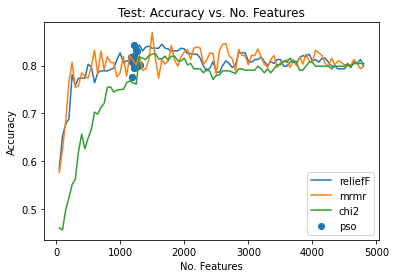

In [71]:
for name, result in results.items():
  k, train, test = zip(*result)
  if name == "pso":
    plt.scatter(k, test, label=name)
  else:
    plt.plot(k, test, label=name)

plt.title("Test: Accuracy vs. No. Features")
plt.xlabel("No. Features")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(fname=f"accuracy-features-{dataset}-test", dpi=500)
plt.show()

In [50]:
print(results)

{'reliefF': [(50, 0.812469586315087, 0.5847222222222221), (100, 0.9155893685010833, 0.6527777777777778), (150, 0.9307986567918654, 0.6777777777777778), (200, 0.9489223465963705, 0.6888888888888889), (250, 0.9585619228912947, 0.7805555555555556), (300, 0.9720060455798996, 0.7583333333333333), (350, 0.9726293413559967, 0.773611111111111), (400, 0.9730705960077778, 0.773611111111111), (450, 0.9747890865972358, 0.7736111111111111), (500, 0.9782143163382552, 0.8027777777777778), (550, 0.9774904106143495, 0.7972222222222223), (600, 0.9795582594479029, 0.763888888888889), (650, 0.9795582594479029, 0.7847222222222222), (700, 0.9810218197824311, 0.7888888888888889), (750, 0.9810218197824311, 0.7888888888888889), (800, 0.9824366471734892, 0.7888888888888889), (850, 0.9857473432685657, 0.7916666666666667), (900, 0.9843325158775074, 0.7944444444444445), (950, 0.9839442243601836, 0.8125), (1000, 0.9839929573036533, 0.8263888888888887), (1050, 0.9840416902471232, 0.8055555555555556), (1100, 0.983992

In [52]:
results['pso']
local = {'reliefF': [(50, 0.812469586315087, 0.5847222222222221), (100, 0.9155893685010833, 0.6527777777777778), (150, 0.9307986567918654, 0.6777777777777778), (200, 0.9489223465963705, 0.6888888888888889), (250, 0.9585619228912947, 0.7805555555555556), (300, 0.9720060455798996, 0.7583333333333333), (350, 0.9726293413559967, 0.773611111111111), (400, 0.9730705960077778, 0.773611111111111), (450, 0.9747890865972358, 0.7736111111111111), (500, 0.9782143163382552, 0.8027777777777778), (550, 0.9774904106143495, 0.7972222222222223), (600, 0.9795582594479029, 0.763888888888889), (650, 0.9795582594479029, 0.7847222222222222), (700, 0.9810218197824311, 0.7888888888888889), (750, 0.9810218197824311, 0.7888888888888889), (800, 0.9824366471734892, 0.7888888888888889), (850, 0.9857473432685657, 0.7916666666666667), (900, 0.9843325158775074, 0.7944444444444445), (950, 0.9839442243601836, 0.8125), (1000, 0.9839929573036533, 0.8263888888888887), (1050, 0.9840416902471232, 0.8055555555555556), (1100, 0.9839929573036533, 0.8097222222222221), (1150, 0.9836046657863295, 0.8097222222222221), (1200, 0.9839929573036535, 0.8180555555555555), (1250, 0.9848701502861095, 0.826388888888889), (1300, 0.9863337106206377, 0.8430555555555556), (1350, 0.9872109036030938, 0.8305555555555555), (1400, 0.989014022511476, 0.8388888888888888), (1450, 0.989014022511476, 0.8402777777777779), (1500, 0.989014022511476, 0.836111111111111), (1550, 0.98808809658555, 0.836111111111111), (1600, 0.9889652895680061, 0.836111111111111), (1650, 0.9871621706596241, 0.8444444444444444), (1700, 0.9889165566245364, 0.836111111111111), (1750, 0.9880393636420802, 0.8347222222222221), (1800, 0.988427655159404, 0.8291666666666666), (1850, 0.9878720996038484, 0.8305555555555555), (1900, 0.9869949066213921, 0.8305555555555555), (1950, 0.9875812739734642, 0.836111111111111), (2000, 0.9875812739734642, 0.8347222222222221), (2050, 0.9885071998993901, 0.825), (2100, 0.9911387788467586, 0.825), (2150, 0.9902615858643025, 0.8236111111111111), (2200, 0.9902615858643025, 0.8236111111111111), (2250, 0.9908171414198579, 0.8152777777777779), (2300, 0.99262026032824, 0.798611111111111), (2350, 0.99262026032824, 0.7888888888888889), (2400, 0.99262026032824, 0.7944444444444444), (2450, 0.9921134377161541, 0.8083333333333333), (2500, 0.9929906306986103, 0.7861111111111112), (2550, 0.9938678236810665, 0.7861111111111112), (2600, 0.9929418977551405, 0.8), (2650, 0.9924042633465383, 0.8097222222222221), (2700, 0.9915270703640822, 0.8041666666666666), (2750, 0.9933301892724643, 0.7958333333333334), (2800, 0.9933301892724643, 0.8013888888888889), (2850, 0.9930264729925172, 0.8263888888888887), (2900, 0.9944413003835754, 0.8263888888888887), (2950, 0.9944413003835754, 0.8263888888888887), (3000, 0.9944413003835754, 0.8097222222222221), (3050, 0.9944233792366222, 0.8069444444444445), (3100, 0.9944413003835754, 0.8125), (3150, 0.99388574482802, 0.8125), (3200, 0.9953005722190783, 0.8180555555555558), (3250, 0.9953005722190783, 0.8083333333333333), (3300, 0.9956888637364021, 0.8), (3350, 0.9956888637364021, 0.8083333333333333), (3400, 0.9962264981450041, 0.8041666666666666), (3450, 0.995349305162548, 0.8125), (3500, 0.9959048607181036, 0.8125), (3550, 0.9959048607181036, 0.798611111111111), (3600, 0.9959048607181036, 0.798611111111111), (3650, 0.9959048607181036, 0.8069444444444442), (3700, 0.9959048607181036, 0.8111111111111111), (3750, 0.9959048607181036, 0.8069444444444442), (3800, 0.9959048607181036, 0.8152777777777779), (3850, 0.9959048607181036, 0.8208333333333332), (3900, 0.995349305162548, 0.8180555555555558), (3950, 0.995349305162548, 0.8236111111111111), (4000, 0.995349305162548, 0.8097222222222221), (4050, 0.99588693957115, 0.8125), (4100, 0.9953493051625479, 0.8069444444444442), (4150, 0.9953493051625479, 0.8152777777777779), (4200, 0.9947937496069924, 0.8152777777777779), (4250, 0.9962264981450041, 0.8069444444444442), (4300, 0.9962264981450041, 0.7986111111111112), (4350, 0.9962264981450041, 0.7986111111111112), (4400, 0.9967820537005597, 0.7930555555555556), (4450, 0.9962264981450041, 0.7930555555555556), (4500, 0.9967820537005597, 0.7930555555555556), (4550, 0.9967820537005597, 0.8013888888888889), (4600, 0.9967820537005597, 0.7958333333333333), (4650, 0.9967820537005597, 0.8069444444444442), (4700, 0.9962264981450041, 0.8041666666666668), (4750, 0.9967820537005597, 0.8125), (4800, 0.9967820537005597, 0.7986111111111112)], 'mrmr': [(50, 0.7895991853207474, 0.6152777777777778), (100, 0.9051109322671291, 0.675), (150, 0.9161370679876623, 0.7097222222222223), (200, 0.9517931069119523, 0.748611111111111), (250, 0.9621118003545848, 0.7583333333333333), (300, 0.9583901755039275, 0.7930555555555555), (350, 0.9652198760178388, 0.7597222222222222), (400, 0.9699084179984009, 0.7763888888888888), (450, 0.9743352271196073, 0.8097222222222223), (500, 0.9739160707242203, 0.7805555555555554), (550, 0.9745859271835503, 0.798611111111111), (600, 0.9749075646104508, 0.7402777777777778), (650, 0.9753807171888665, 0.8125), (700, 0.9794049721893524, 0.7916666666666666), (750, 0.9796557253348425, 0.773611111111111), (800, 0.9838704818416193, 0.8013888888888887), (850, 0.9812428472615229, 0.7916666666666666), (900, 0.9831824184116205, 0.8166666666666667), (950, 0.9814101112997549, 0.8013888888888889), (1000, 0.9873083694900334, 0.8041666666666668), (1050, 0.9837816764132553, 0.8180555555555555), (1100, 0.985086147267811, 0.8305555555555555), (1150, 0.9825033012639125, 0.7916666666666667), (1200, 0.986937999119663, 0.8041666666666666), (1250, 0.9863824435641074, 0.8319444444444445), (1300, 0.98808809658555, 0.8472222222222221), (1350, 0.9882912029176885, 0.8305555555555555), (1400, 0.9873083694900334, 0.8277777777777777), (1450, 0.9859910079859147, 0.8222222222222222), (1500, 0.9885917751367668, 0.8347222222222221), (1550, 0.9858935420989751, 0.8125), (1600, 0.9852892535999498, 0.8402777777777777), (1650, 0.9851707225051877, 0.8013888888888887), (1700, 0.9893843928818462, 0.8055555555555556), (1750, 0.9890627554549456, 0.8277777777777778), (1800, 0.9903282399547255, 0.8486111111111111), (1850, 0.9863305665597686, 0.8055555555555556), (1900, 0.9873083694900334, 0.8027777777777778), (1950, 0.9902795070112557, 0.825), (2000, 0.9935949191976358, 0.8041666666666666), (2050, 0.9944541910331385, 0.8569444444444443), (2100, 0.9906498773816261, 0.8375), (2150, 0.9903103188077722, 0.8111111111111111), (2200, 0.9930085518455638, 0.8152777777777779), (2250, 0.9910381688989499, 0.8111111111111111), (2300, 0.990359051751242, 0.8125), (2350, 0.9919640948248759, 0.8055555555555556), (2400, 0.9924042633465385, 0.8305555555555554), (2450, 0.9942561151983902, 0.8166666666666667), (2500, 0.9921313588631075, 0.8180555555555555), (2550, 0.9930475382003395, 0.8), (2600, 0.9927925548638623, 0.8208333333333334), (2650, 0.9953493051625479, 0.8152777777777779), (2700, 0.993612840344589, 0.7999999999999999), (2750, 0.9948116707539458, 0.8236111111111111), (2800, 0.9924529962900082, 0.8027777777777777), (2850, 0.9962264981450041, 0.7958333333333333), (2900, 0.9918974407344526, 0.8152777777777777), (2950, 0.9956888637364021, 0.8111111111111111), (3000, 0.9942740363453437, 0.8180555555555555), (3050, 0.9942561151983902, 0.8208333333333332), (3100, 0.993612840344589, 0.7861111111111111), (3150, 0.9948116707539458, 0.7902777777777777), (3200, 0.9956888637364021, 0.8291666666666666), (3250, 0.9971036911274602, 0.8041666666666666), (3300, 0.9915758033075521, 0.8125), (3350, 0.9976592466830159, 0.8277777777777778), (3400, 0.9962264981450041, 0.8319444444444443), (3450, 0.9965481355719048, 0.8291666666666666), (3500, 0.9942561151983902, 0.8152777777777779), (3550, 0.995349305162548, 0.8291666666666668), (3600, 0.9953493051625479, 0.7958333333333333), (3650, 0.9939165566245365, 0.7888888888888889), (3700, 0.9953005722190783, 0.8319444444444445), (3750, 0.9959048607181036, 0.8236111111111111), (3800, 0.9951333081808464, 0.8069444444444442), (3850, 0.9953672263095014, 0.8125), (3900, 0.9951512293277999, 0.8416666666666666), (3950, 0.9962264981450041, 0.8152777777777777), (4000, 0.9967820537005597, 0.8069444444444442), (4050, 0.9967820537005597, 0.8041666666666668), (4100, 0.9953493051625479, 0.8291666666666666), (4150, 0.9953493051625479, 0.8152777777777779), (4200, 0.9962264981450041, 0.8013888888888889), (4250, 0.9967820537005597, 0.7986111111111112), (4300, 0.9962264981450041, 0.8013888888888889), (4350, 0.9953493051625479, 0.8152777777777777), (4400, 0.9962264981450041, 0.7986111111111112), (4450, 0.9967820537005597, 0.8208333333333332), (4500, 0.9967820537005597, 0.8041666666666668), (4550, 0.9959048607181036, 0.7930555555555555), (4600, 0.9967820537005597, 0.826388888888889), (4650, 0.9967820537005597, 0.8069444444444442), (4700, 0.9967820537005597, 0.8041666666666668), (4750, 0.9962264981450041, 0.7986111111111112), (4800, 0.9967820537005597, 0.7986111111111112)], 'chi2': [(50, 0.7154292541389315, 0.4611111111111111), (100, 0.8141635818121384, 0.4569444444444445), (150, 0.8860081288264651, 0.49861111111111106), (200, 0.906022856914198, 0.5236111111111111), (250, 0.9280571214611962, 0.5513888888888889), (300, 0.9426398433359384, 0.5625), (350, 0.9530131781065568, 0.6208333333333333), (400, 0.9586066869683169, 0.6569444444444443), (450, 0.9620627285058525, 0.6263888888888889), (500, 0.96320465141348, 0.648611111111111), (550, 0.9669602321215225, 0.6666666666666665), (600, 0.9711220254938422, 0.7027777777777778), (650, 0.9722721229597291, 0.6986111111111112), (700, 0.9702003297589036, 0.7125000000000001), (750, 0.973312635613145, 0.7208333333333333), (800, 0.9760904133909227, 0.7541666666666667), (850, 0.9775758392396762, 0.7555555555555555), (900, 0.97822697424565, 0.7444444444444444), (950, 0.9814807628389971, 0.7486111111111111), (1000, 0.9814807628389971, 0.75), (1050, 0.9820363183945526, 0.75), (1100, 0.9809610495773484, 0.763888888888889), (1150, 0.9829801654674319, 0.7680555555555556), (1200, 0.9838573584498882, 0.7638888888888888), (1250, 0.9851886436521411, 0.7611111111111111), (1300, 0.9866701251336225, 0.8180555555555555), (1350, 0.9862818336162988, 0.8152777777777777), (1400, 0.9841391561340629, 0.8124999999999998), (1450, 0.9849984279695656, 0.8208333333333332), (1500, 0.9864132553606237, 0.8236111111111111), (1550, 0.9886046657863297, 0.8249999999999998), (1600, 0.9871898383952713, 0.8138888888888888), (1650, 0.9857262780607433, 0.8138888888888888), (1700, 0.9857262780607433, 0.8194444444444443), (1750, 0.9871411054518016, 0.8111111111111111), (1800, 0.9868015468779475, 0.8194444444444443), (1850, 0.9877274728038735, 0.8194444444444443), (1900, 0.9868502798214174, 0.8097222222222221), (1950, 0.9868502798214174, 0.8097222222222221), (2000, 0.9859730868389611, 0.8152777777777777), (2050, 0.9877762057473433, 0.8013888888888889), (2100, 0.9907473432685656, 0.8041666666666668), (2150, 0.9907473432685656, 0.7930555555555555), (2200, 0.9898214173426398, 0.7930555555555555), (2250, 0.9916245362510218, 0.7930555555555555), (2300, 0.9907473432685657, 0.7847222222222222), (2350, 0.9916245362510219, 0.7930555555555555), (2400, 0.9916245362510219, 0.7875), (2450, 0.9939344777714897, 0.7708333333333334), (2500, 0.9939344777714897, 0.7791666666666667), (2550, 0.9930572847890335, 0.7805555555555557), (2600, 0.9930572847890335, 0.7888888888888889), (2650, 0.9921800918065774, 0.788888888888889), (2700, 0.9944721121800917, 0.788888888888889), (2750, 0.9944721121800917, 0.7861111111111112), (2800, 0.9953493051625479, 0.7833333333333334), (2850, 0.9944721121800917, 0.7930555555555555), (2900, 0.9948116707539458, 0.7930555555555555), (2950, 0.9953493051625479, 0.7902777777777777), (3000, 0.9944721121800917, 0.7902777777777777), (3050, 0.9962264981450041, 0.7902777777777777), (3100, 0.9962264981450041, 0.7902777777777777), (3150, 0.9953493051625479, 0.7986111111111112), (3200, 0.9951153870338929, 0.7930555555555555), (3250, 0.9956709425894485, 0.7847222222222222), (3300, 0.9939165566245363, 0.7930555555555555), (3350, 0.9939165566245363, 0.7847222222222222), (3400, 0.9953493051625479, 0.7930555555555555), (3450, 0.9953493051625479, 0.8013888888888889), (3500, 0.9944721121800919, 0.8013888888888889), (3550, 0.9944721121800919, 0.8097222222222221), (3600, 0.9944721121800919, 0.8069444444444442), (3650, 0.9944721121800919, 0.8152777777777779), (3700, 0.9941504747531912, 0.8069444444444442), (3750, 0.9941504747531912, 0.8069444444444442), (3800, 0.9950276677356473, 0.7902777777777777), (3850, 0.9950276677356473, 0.7902777777777777), (3900, 0.9950276677356473, 0.798611111111111), (3950, 0.9950276677356473, 0.8069444444444442), (4000, 0.9959048607181036, 0.8069444444444442), (4050, 0.9941504747531912, 0.7986111111111112), (4100, 0.9959048607181036, 0.7986111111111112), (4150, 0.9950276677356473, 0.7986111111111112), (4200, 0.9950276677356473, 0.7986111111111112), (4250, 0.9950276677356473, 0.7986111111111112), (4300, 0.9950276677356473, 0.7930555555555555), (4350, 0.9950276677356473, 0.7986111111111112), (4400, 0.9950276677356473, 0.7986111111111112), (4450, 0.9950276677356473, 0.7986111111111112), (4500, 0.9959048607181036, 0.7986111111111112), (4550, 0.9959048607181036, 0.8041666666666668), (4600, 0.9959048607181036, 0.7986111111111112), (4650, 0.9967820537005597, 0.8041666666666668), (4700, 0.9967820537005597, 0.8041666666666668), (4750, 0.9962264981450041, 0.8041666666666668), (4800, 0.9967820537005597, 0.8041666666666668)], 'pso': [(1256, 0.9906190655851097, 0.8305555555555555), (1218, 0.9831157643211974, 0.7944444444444444), (1274, 0.985580079230334, 0.7986111111111112), (1236, 0.9888954914167138, 0.8125), (1261, 0.9853559076903728, 0.8013888888888889), (1220, 0.9856467333207573, 0.7972222222222223), (1170, 0.9862151795258758, 0.8180555555555555), (1223, 0.9858268880085518, 0.8208333333333334), (1186, 0.9849676161730491, 0.8069444444444442), (1302, 0.9846459787461486, 0.8013888888888889), (1184, 0.990112242973024, 0.7763888888888889), (1243, 0.9866732691944916, 0.8319444444444443), (1213, 0.9870923725083317, 0.8180555555555555), (1212, 0.9873492422813305, 0.8097222222222221), (1223, 0.9831465761177137, 0.8430555555555556)]}

In [68]:
for method, result in results.items():
    k, train, test = list(zip(*result))
    best_k = np.argmax(test)
    print(f"{method} performed best at {k[best_k]} features, with {train[best_k]} training accuracy, and {test[best_k]} test accuracy.")

k, train, test = results['mrmr'][-1]
print(f"Full-dataset with {k} features, with {train} training accuracy, and {test} test accuracy.")

reliefF performed best at 1650 features, with 0.9871621706596241 training accuracy, and 0.8444444444444444 test accuracy.
mrmr performed best at 1500 features, with 0.9914214299188833 training accuracy, and 0.8694444444444445 test accuracy.
chi2 performed best at 1550 features, with 0.9886046657863297 training accuracy, and 0.8249999999999998 test accuracy.
pso performed best at 1223 features, with 0.9831465761177137 training accuracy, and 0.8430555555555556 test accuracy.
Full-dataset with 4800 features, with 0.9967820537005597 training accuracy, and 0.7986111111111112 test accuracy.


In [70]:
from prettytable import PrettyTable

def show_results(results, label='Method'):
    table = PrettyTable([label, 'Best K', 'Train', 'Test'])

    for name, result in results.items():
        k, train, test = list(zip(*result))
        best_k = np.argmax(test)
        vals = [k[best_k], train[best_k], test[best_k]]
        row = ['%.4f' % elem if i != 0 else elem for i, elem in enumerate(vals) ]
        table.add_row(np.concatenate([[name], row]))

    k, train, test = results['mrmr'][-1]
    vals = [k, train, test]
    row = ['%.4f' % elem if i != 0 else elem for i, elem in enumerate(vals) ]
    table.add_row(np.concatenate([['full'], row]))

    print('\n') # tqdm messses with table border.
    print(table)

show_results(results)



+---------+--------+--------+--------+
|  Method | Best K | Train  |  Test  |
+---------+--------+--------+--------+
| reliefF |  1650  | 0.9872 | 0.8444 |
|   mrmr  |  1500  | 0.9914 | 0.8694 |
|   chi2  |  1550  | 0.9886 | 0.8250 |
|   pso   |  1223  | 0.9831 | 0.8431 |
|   full  |  4800  | 0.9968 | 0.7986 |
+---------+--------+--------+--------+
